In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animate  
import timecorr as tc
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn.datasets import fetch_atlas_harvard_oxford

from matplotlib.colors import ListedColormap
list_cmap = ListedColormap(["lawngreen", "violet", "cornflowerblue"])
%matplotlib inline

/data/jdecke5/.conda/envs/swfc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [17]:
strucdat = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/struc_masked_conf_data.npy")
randdat = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/rand_masked_conf_data.npy")
labels = pd.read_csv("/data/jdecke5/projects/honors-thesis/data/eventseg/labels.csv")
labels = list(labels["labels"])
atlas_filename = fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm").maps

# Compute static FC

## Structured group

In [23]:
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
struc_corr = correlation_measure.fit_transform([strucdat.mean(0)])[0]

Extract labels

In [19]:
coords = plotting.find_parcellation_cut_coords(
    labels_img=atlas_filename)

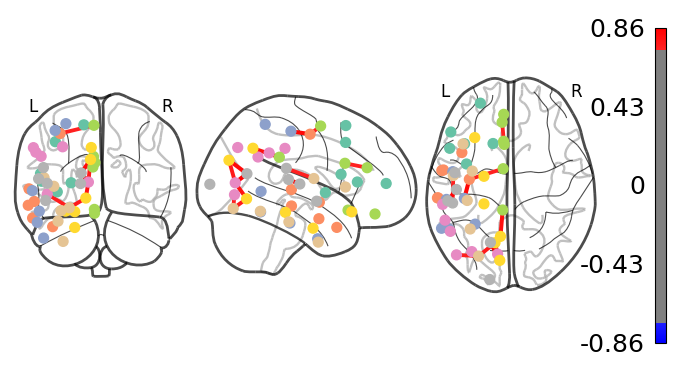

In [22]:
struc_brain = plotting.plot_connectome(
    struc_corr, coords, 
    edge_threshold="99%", colorbar=True
)

plotting.show()

## Random group

In [25]:
rand_corr = correlation_measure.fit_transform([randdat.mean(0)])[0]

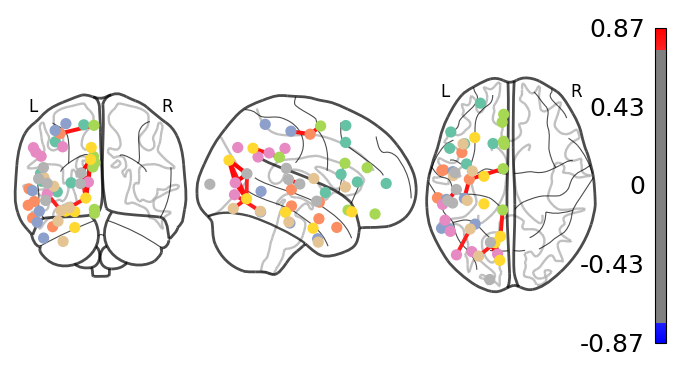

In [26]:
rand_brain = plotting.plot_connectome(
    rand_corr, coords, 
    edge_threshold="99%", colorbar=True
)

plotting.show()

Get the difference between these two brains

In [49]:
diff = np.abs(struc_corr - rand_corr)

Plot

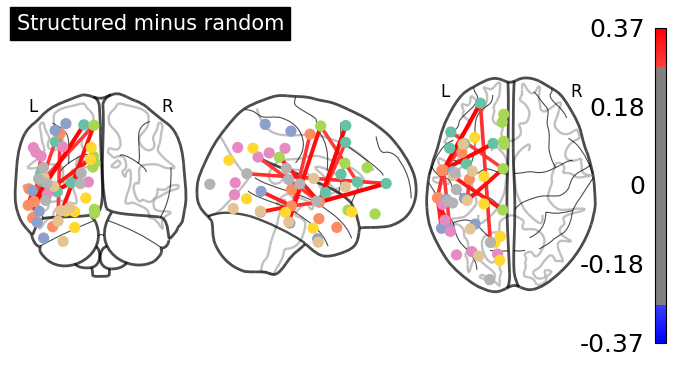

In [32]:
diff_brain = plotting.plot_connectome(
    diff, coords, 
    edge_threshold="99%", colorbar=True
)

diff_brain.title('Structured minus random')
plotting.show()
diff_brain.savefig("/data/jdecke5/projects/honors-thesis/data/swfc/diff_brain.png", dpi=800)

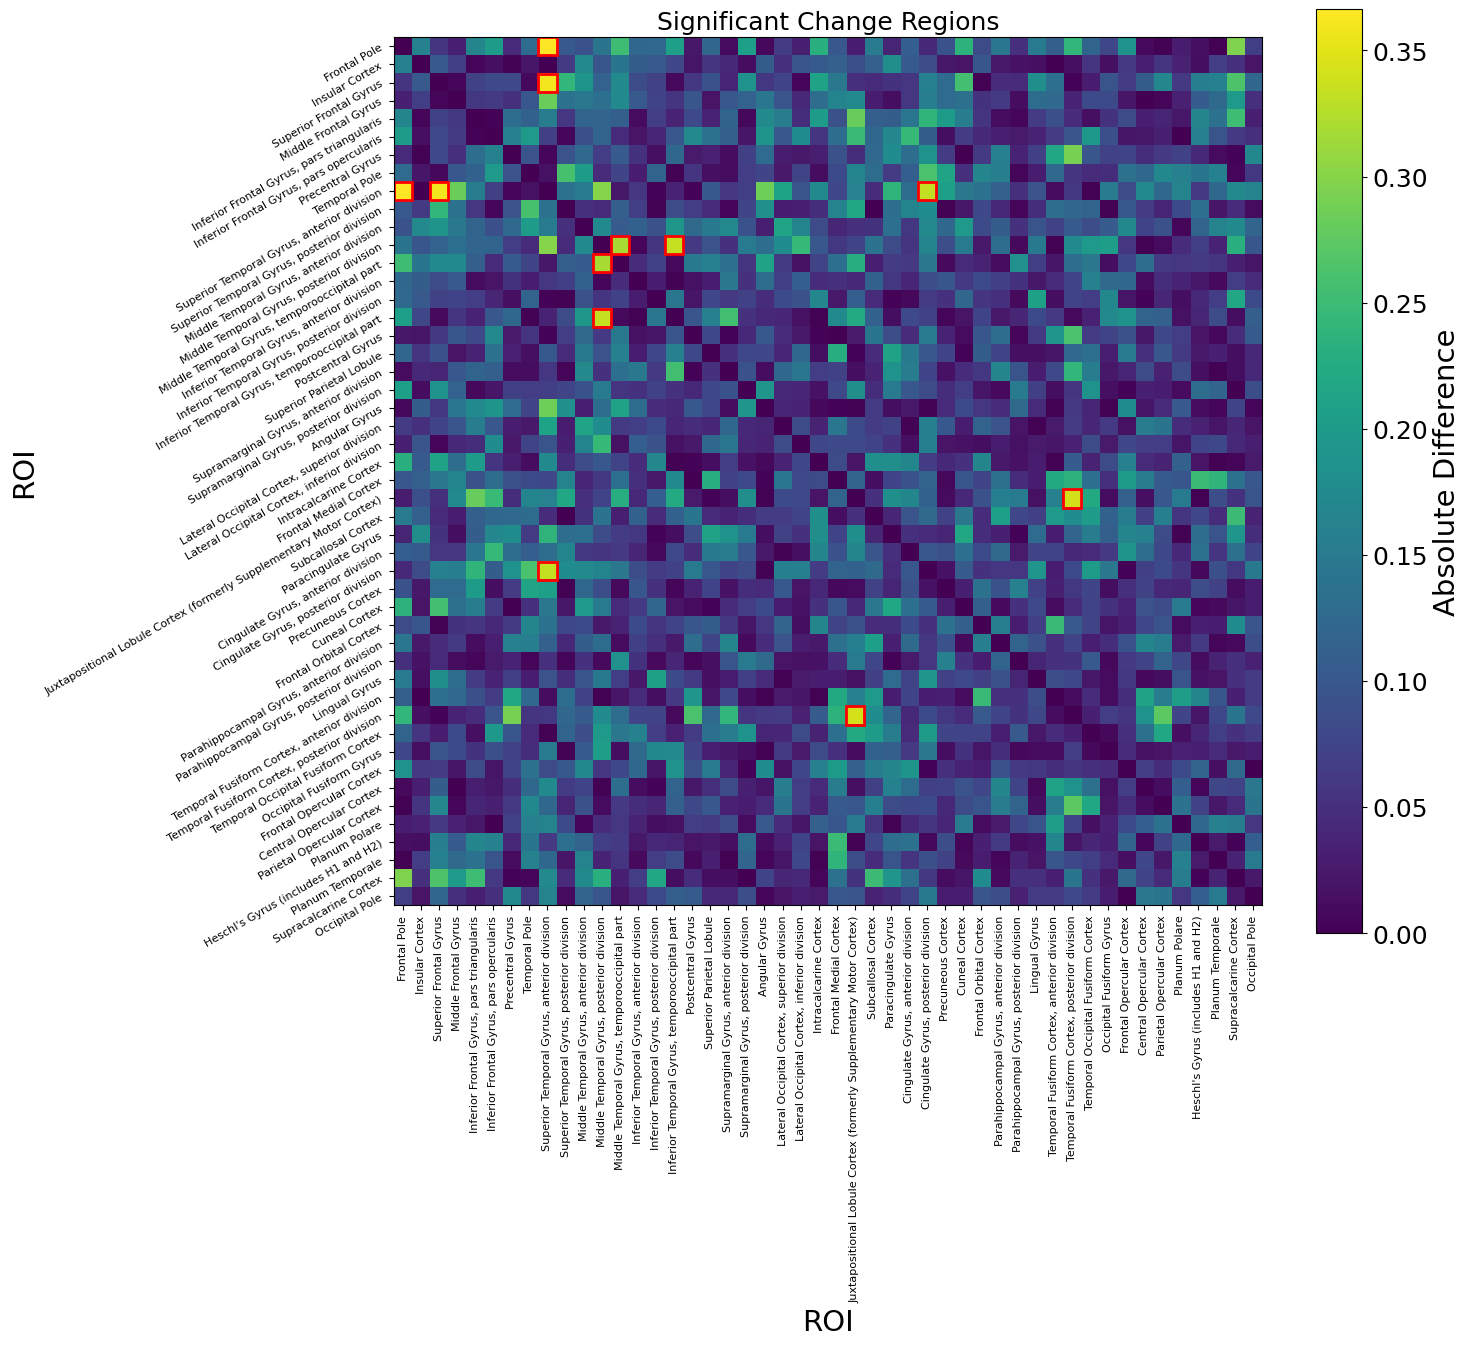

In [57]:
# set diff threshold
threshold = 0.3

# get idx from threshold
significant_indices = np.argwhere(diff > threshold)

#Plot
fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(diff, cmap='viridis', )

# Add patches for significant regions
for index in significant_indices:
    rect = Rectangle((index[1]-0.5, index[0]-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

cbar = plt.colorbar(im, ax=ax, label='Absolute Difference')

ax.set_title('Significant Change Regions')
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')

ax.set_yticks(range(len(labels)), labels, rotation=30, fontsize=8)
ax.set_xticks(range(len(labels)), labels, rotation=90, fontsize=8)

fig.savefig("/data/jdecke5/projects/honors-thesis/data/swfc/diff_mat.png", dpi=800, bbox_inches='tight')

# Compute dynamic FC

Set some parameters

In [58]:
width = 44
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}

conver data to list type

In [59]:
struc_list = []
[struc_list.append(i) for i in strucdat]

rand_list = []
[rand_list.append(i) for i in randdat]

[None, None, None, None, None, None, None, None, None]

## Structured dFC

In [62]:
struc_vec_corrs = tc.timecorr(struc_list, 
                              weights_function=gaussian['weights'], 
                              weights_params=gaussian['params'], 
                              combine=tc.corrmean_combine)

print('vectorized shape : ' + str(np.shape(struc_vec_corrs)))

vectorized shape : (240, 1176)


transform back into matrix

In [63]:
# use the vec2mat function to convert vectorized correlations to moment-by-moment full correlations
struc_mat_corrs = tc.vec2mat(struc_vec_corrs)

# return the dynamic full correlations
print('matrix shape : ' + str(np.shape(struc_mat_corrs)))

matrix shape : (48, 48, 240)


set diag

In [64]:
X = [np.fill_diagonal(struc_mat_corrs[:, :, i], 0) for i in range(240)]

animate and save

MovieWriter ffmpeg unavailable; using Pillow instead.


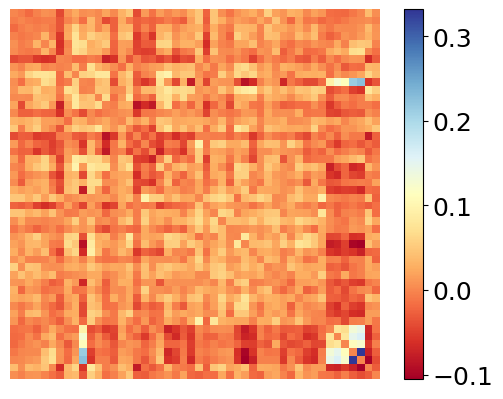

In [67]:
mat = []

fig = plt.figure()

for i in range(240):
    im = plt.imshow(struc_mat_corrs[:, :, i], animated=True, cmap='RdYlBu')
    mat.append([im])

ani = animate.ArtistAnimation(fig, mat, interval=25,\
    blit=True, repeat_delay=500)
plt.axis('off')
plt.colorbar()
ani.save('/data/jdecke5/projects/honors-thesis/data/swfc/struc_dfc.gif')

## Random dFC

In [68]:
rand_vec_corrs = tc.timecorr(rand_list, 
                              weights_function=gaussian['weights'], 
                              weights_params=gaussian['params'], 
                              combine=tc.corrmean_combine)

print('vectorized shape : ' + str(np.shape(rand_vec_corrs)))

vectorized shape : (240, 1176)


transform back into matrix

In [69]:
# use the vec2mat function to convert vectorized correlations to moment-by-moment full correlations
rand_mat_corrs = tc.vec2mat(rand_vec_corrs)

# return the dynamic full correlations
print('matrix shape : ' + str(np.shape(rand_mat_corrs)))

matrix shape : (48, 48, 240)


set diag

In [70]:
X = [np.fill_diagonal(rand_mat_corrs[:, :, i], 0) for i in range(240)]

animate and save

MovieWriter ffmpeg unavailable; using Pillow instead.


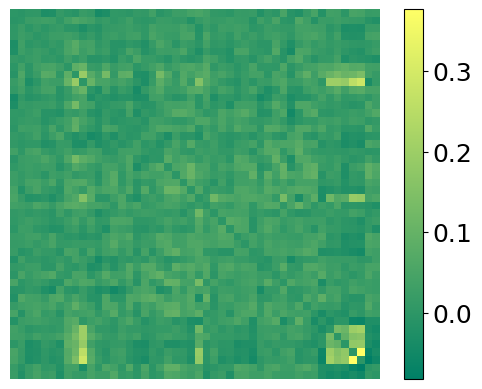

In [71]:
mat = []

fig = plt.figure()

for i in range(240):
    im = plt.imshow(rand_mat_corrs[:, :, i], animated=True, cmap='summer')
    mat.append([im])

ani = animate.ArtistAnimation(fig, mat, interval=25,\
    blit=True, repeat_delay=500)
plt.axis('off')
plt.colorbar()
ani.save('/data/jdecke5/projects/honors-thesis/data/swfc/rand_dfc.gif')

# `KMeans` over time

## Find best $k$ using WCSS

reshape data

In [74]:
struc_data_reshaped = np.reshape(struc_mat_corrs, (-1, struc_mat_corrs.shape[2]))

In [75]:
# store 
wcss = []

# Which Ks to test
k_values = range(1, 11)

# Calculate the within-cluster sum of squares for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(struc_data_reshaped)
    wcss.append(kmeans.inertia_)

plot as save

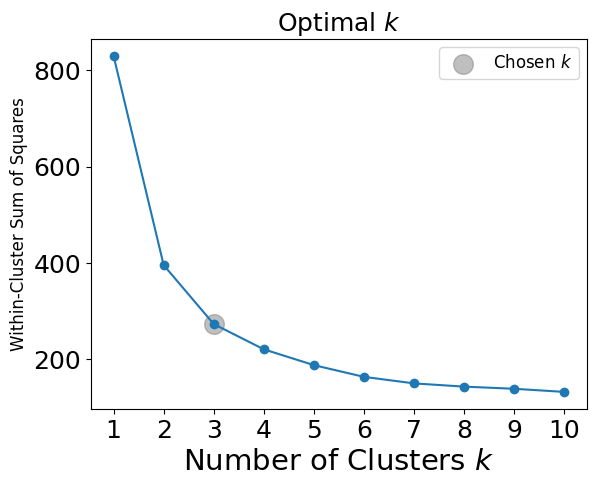

In [145]:
# Plot elbow
plt.plot(k_values, wcss, marker='o')
plt.title('Optimal $k$')
plt.xlabel('Number of Clusters $k$')
plt.ylabel('Within-Cluster Sum of Squares', fontsize=12)
plt.scatter(3, 272, marker='o',color='grey',alpha=0.5, s=200, label=f"Chosen $k$")
plt.xticks(k_values)
plt.legend(fontsize=12)

# save
plt.savefig('/data/jdecke5/projects/honors-thesis/data/swfc/optimalK.png', bbox_inches='tight', dpi=800)

Clustering

In [109]:
# number of clusters
n_clusters = 3

# Initialize and fit the k-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(struc_data_reshaped)

# Get the cluster labels for each matrix
cluster_labels = kmeans.labels_

# Reshape cluster labels back to the original shaoe
cluster_labels_matrix = np.reshape(cluster_labels, (struc_mat_corrs.shape[0], struc_mat_corrs.shape[1]))

plot clusters and save

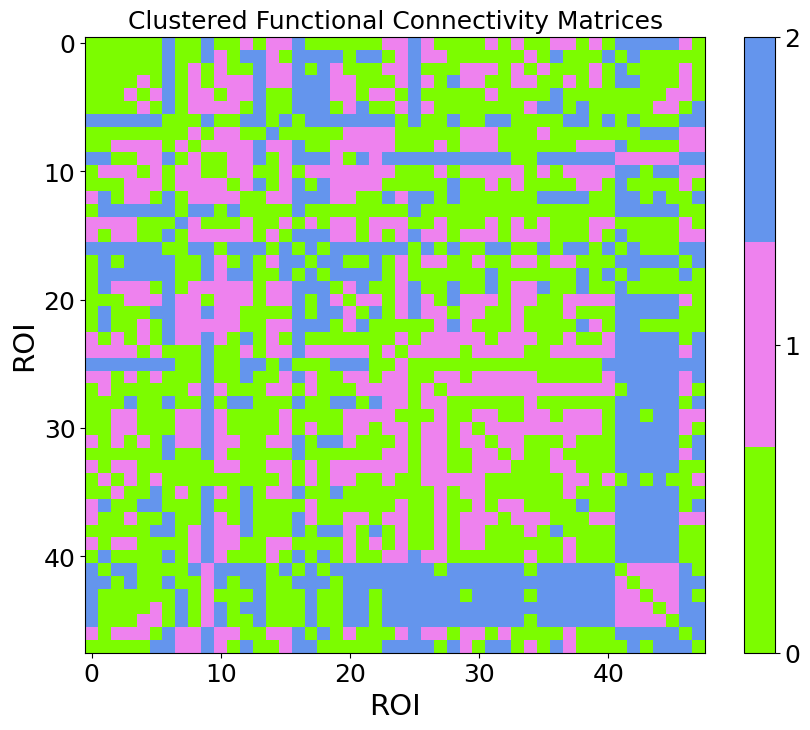

In [143]:
plt.figure(figsize=(10, 8))
plt.imshow(cluster_labels_matrix, cmap=list_cmap, aspect='auto')
plt.title('Clustered Functional Connectivity Matrices')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.colorbar(ticks=[0, 1, 2])  # Set discrete ticks

# save fig
plt.savefig('/data/jdecke5/projects/honors-thesis/data/swfc/struc_clusters.png', dpi=800)

# Some more plotting for teaching

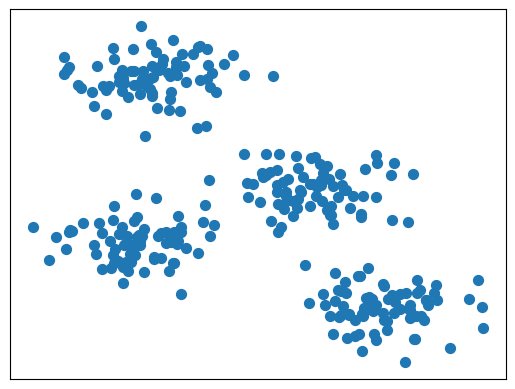

In [6]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);
plt.yticks([])
plt.xticks([])

plt.savefig('/data/jdecke5/projects/honors-thesis/data/swfc/blobs.png', dpi=800)

Cluster

In [9]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

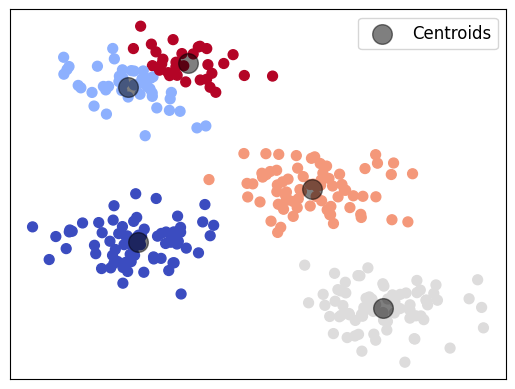

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='coolwarm')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='Centroids');
plt.legend(fontsize=12)

plt.yticks([])
plt.xticks([])

plt.savefig('/data/jdecke5/projects/honors-thesis/data/swfc/example_cluster.png', dpi=800)